###### Data Preparation



## Data Overview 

Import the numpy and pandas modules.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Data Description

### Transaction Table 
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

## Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id_12 - id_38

In [2]:
transaction_df = pd.read_csv('./ieee-data/train_transaction.csv')
identity_df = pd.read_csv('./ieee-data/train_identity.csv')
test_transaction = pd.read_csv('./ieee-data/test_transaction.csv')
test_identity = pd.read_csv('./ieee-data/test_identity.csv')

In [3]:
id_cols = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain']
cat_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
train_data_ratio = 0.8

Based on the train/test ratio we assigned before, extact the IDs of test data. 

In [4]:
n_train = int(transaction_df.shape[0]*train_data_ratio)
test_ids = transaction_df.TransactionID.values[n_train:]

In [5]:
get_fraud_frac = lambda series: 100 * sum(series)/len(series)
print("Percent fraud for train transactions: {}".format(get_fraud_frac(transaction_df.isFraud[:n_train])))
print("Percent fraud for test transactions: {}".format(get_fraud_frac(transaction_df.isFraud[n_train:])))
print("Percent fraud for all transactions: {}".format(get_fraud_frac(transaction_df.isFraud)))

Percent fraud for train transactions: 3.5135215226741625
Percent fraud for test transactions: 3.4409184813899145
Percent fraud for all transactions: 3.499000914417313


 Save test IDs into the `test.csv` file

In [6]:
with open('data/test.csv', 'w') as f:
    f.writelines(map(lambda x: str(x) + "\n", test_ids))

Based on the standard we talked about before, define non-feature-columns and feature-columns for creating graph.

In [7]:
non_feature_cols = ['isFraud', 'TransactionDT'] + id_cols
print(non_feature_cols)

['isFraud', 'TransactionDT', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']


In [8]:
feature_cols = [col for col in transaction_df.columns if col not in non_feature_cols]
print(feature_cols)

['TransactionID', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102',

Transfer categorical features to be dummy variables and scale the `TransactionAmt` feature by log10.

In [9]:
features = pd.get_dummies(transaction_df[feature_cols], columns=cat_cols).fillna(0)
features['TransactionAmt'] = features['TransactionAmt'].apply(np.log10)

In [10]:
features.shape

(590540, 391)

In [11]:
print(list(features.columns))

['TransactionID', 'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109

Save the features into `features.csv` for future training. 

p.s. We don't need the index column and header.

In [12]:
features.to_csv('data/features.csv', index=False, header=False)

Save the IDs and label into the `tags.csv`.

In [13]:
transaction_df[['TransactionID', 'isFraud']].to_csv('data/tags_new.csv', index=False)

Select the columns that define the edges.

In [14]:
edge_types = id_cols + list(identity_df.columns)
print(edge_types)

['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


# HANDLING IMBALANCE DATA:

In [15]:
all_id_cols = ['TransactionID'] +['isFraud']+ id_cols
full_identity_df = transaction_df[all_id_cols].merge(identity_df, on='TransactionID', how='left')
full_identity_df.head(5)

TransactionID  isFraud  card1  card2  card3       card4  card5   card6  \
0        2987000        0  13926    NaN  150.0    discover  142.0  credit   
1        2987001        0   2755  404.0  150.0  mastercard  102.0  credit   
2        2987002        0   4663  490.0  150.0        visa  166.0   debit   
3        2987003        0  18132  567.0  150.0  mastercard  117.0   debit   
4        2987004        0   4497  514.0  150.0  mastercard  102.0  credit   

  ProductCD  addr1  ...                id_31 id_32      id_33           id_34  \
0         W  315.0  ...                  NaN   NaN        NaN             NaN   
1         W  325.0  ...                  NaN   NaN        NaN             NaN   
2         W  330.0  ...                  NaN   NaN        NaN             NaN   
3         W  476.0  ...                  NaN   NaN        NaN             NaN   
4         H  420.0  ...  samsung browser 6.2  32.0  2220x1080  match_status:2   

   id_35  id_36  id_37  id_38  DeviceType                     DeviceInfo  
0    NaN    NaN    NaN    NaN         NaN                            NaN  
1    NaN    NaN    NaN    NaN         NaN                            NaN  
2    NaN    NaN    NaN    NaN         NaN                            NaN  
3    NaN    NaN    NaN    NaN         NaN                            NaN  
4      T      F      T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 53 columns]

<Axes: xlabel='isFraud', ylabel='count'>

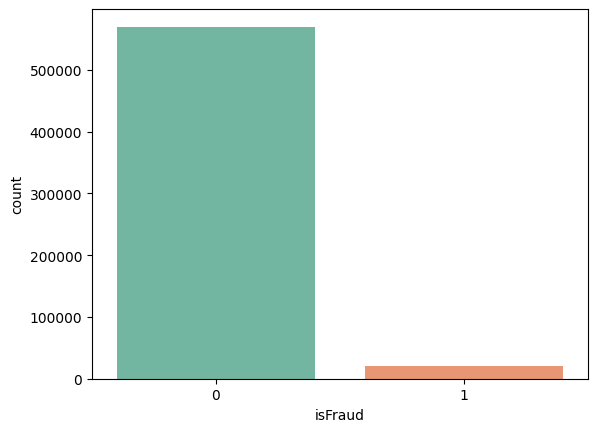

In [16]:
sns.countplot(x=full_identity_df["isFraud"],  palette = "Set2")

From above count_plot we can say that dataset is unbalanced.
Lets perform undersampling for isFraud=0 & SMOTE for for isFraud=1

In [17]:
from imblearn import under_sampling

In [18]:
undsam_df=full_identity_df
X=undsam_df
Y=undsam_df['isFraud']

In [19]:
X.drop('isFraud', axis=1,inplace=True)

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(random_state=0)
x1,y1=rus.fit_resample(X,Y)
print(y1.value_counts(),y1.shape)

0    20663
1    20663
Name: isFraud, dtype: int64 (41326,)


In [21]:
x1.shape

(41326, 52)

In [22]:
full_identity_df=x1

For each identity feature, save the data into the corresponding `relation_{FEATURE NAME}_edgelist.csv`. Each csv file represents one kind of edge.

In [23]:
edges = {}
for etype in edge_types:
    edgelist = full_identity_df[['TransactionID', etype]].dropna()
    edgelist.to_csv('data/relation_{}_edgelist.csv'.format(etype), index=False, header=True)
    edges[etype] = edgelist

print(edges)

{'card1':        TransactionID  card1
0            3491145   3508
1            2990379   8830
2            3219993  12718
3            2987873  12883
4            3019692  12779
...              ...    ...
41321        3577361   3278
41322        3577364   5812
41323        3577368   6758
41324        3577372  14037
41325        3577526   1214

[41326 rows x 2 columns], 'card2':        TransactionID  card2
0            3491145  514.0
1            2990379  250.0
2            3219993  367.0
3            2987873  404.0
4            3019692  100.0
...              ...    ...
41321        3577361  453.0
41322        3577364  408.0
41323        3577368  399.0
41324        3577372  111.0
41325        3577526  174.0

[40602 rows x 2 columns], 'card3':        TransactionID  card3
0            3491145  150.0
1            2990379  150.0
2            3219993  150.0
3            2987873  150.0
4            3019692  150.0
...              ...    ...
41321        3577361  150.0
41322        3577364  

Let's re-check the edges we defined.

In [24]:
import glob

file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

edges_full = ''
for etype in edge_types:
    edges_full += ',data/relation_{}_edgelist.csv'.format(etype)


In [25]:
edges

'relation_TransactionID_edgelist.csv,relation_R_emaildomain_edgelist.csv,relation_P_emaildomain_edgelist.csv,relation_ProductCD_edgelist.csv,relation_id_38_edgelist.csv,relation_id_37_edgelist.csv,relation_id_36_edgelist.csv,relation_id_35_edgelist.csv,relation_id_34_edgelist.csv,relation_id_33_edgelist.csv,relation_id_32_edgelist.csv,relation_id_31_edgelist.csv,relation_id_30_edgelist.csv,relation_id_29_edgelist.csv,relation_id_28_edgelist.csv,relation_id_27_edgelist.csv,relation_id_26_edgelist.csv,relation_id_25_edgelist.csv,relation_id_24_edgelist.csv,relation_id_23_edgelist.csv,relation_id_22_edgelist.csv,relation_id_21_edgelist.csv,relation_id_20_edgelist.csv,relation_id_19_edgelist.csv,relation_id_18_edgelist.csv,relation_id_17_edgelist.csv,relation_id_16_edgelist.csv,relation_id_15_edgelist.csv,relation_id_14_edgelist.csv,relation_id_13_edgelist.csv,relation_id_12_edgelist.csv,relation_id_11_edgelist.csv,relation_id_10_edgelist.csv,relation_id_09_edgelist.csv,relation_id_08_edge

# TRAINING MODEL

In [1]:
import os
import sys
import glob

os.environ['DGLBACKEND'] = 'pytorch'

import torch as th
import dgl
import numpy as np

from gnn.estimator_fns import *
from gnn.graph_utils import *
from gnn.data import *
from gnn.utils import *
from gnn.pytorch_model import *
from train import *

DLG version: 1.0.1


In [2]:
file_list = glob.glob('./data/*edgelist.csv')

edges = ",".join(map(lambda x: x.split("/")[-1], [file for file in file_list if "relation" in file]))

##### GENERATE GRAPH

In [3]:
print('numpy version:{} PyTorch version:{} DGL version:{}'.format(np.__version__,
                                                                    th.__version__,
                                                                    dgl.__version__))

args = parse_args()
print(args)

numpy version:1.24.2 PyTorch version:1.13.1+cu117 DGL version:1.0.1
Namespace(training_dir='./data', model_dir='./model/2023_05_25_14_22_11', output_dir='./output', nodes='features.csv', target_ntype='TransactionID', edges='relation*', labels='tags.csv', new_accounts='test.csv', compute_metrics=True, threshold=0, num_gpus=0, optimizer='adam', lr=0.01, n_epochs=200, n_hidden=16, n_layers=2, weight_decay=0.0001, dropout=0.2, embedding_size=360, n_heads=8, alpha=0.2)


In [4]:
args.edges = edges

args.edges = get_edgelists('relation*', args.training_dir)

g, features, target_id_to_node, id_to_node = construct_graph(args.training_dir,
                                                                args.edges,
                                                                args.nodes,
                                                                args.target_ntype)

mean, stdev, features = normalize(th.from_numpy(features))

print('feature mean shape:{}, std shape:{}'.format(mean.shape, stdev.shape))

Getting relation graphs from the following edge lists : ['relation_TransactionID_edgelist.csv', 'relation_R_emaildomain_edgelist.csv', 'relation_P_emaildomain_edgelist.csv', 'relation_ProductCD_edgelist.csv', 'relation_id_38_edgelist.csv', 'relation_id_37_edgelist.csv', 'relation_id_36_edgelist.csv', 'relation_id_35_edgelist.csv', 'relation_id_34_edgelist.csv', 'relation_id_33_edgelist.csv', 'relation_id_32_edgelist.csv', 'relation_id_31_edgelist.csv', 'relation_id_30_edgelist.csv', 'relation_id_29_edgelist.csv', 'relation_id_28_edgelist.csv', 'relation_id_27_edgelist.csv', 'relation_id_26_edgelist.csv', 'relation_id_25_edgelist.csv', 'relation_id_24_edgelist.csv', 'relation_id_23_edgelist.csv', 'relation_id_22_edgelist.csv', 'relation_id_21_edgelist.csv', 'relation_id_20_edgelist.csv', 'relation_id_19_edgelist.csv', 'relation_id_18_edgelist.csv', 'relation_id_17_edgelist.csv', 'relation_id_16_edgelist.csv', 'relation_id_15_edgelist.csv', 'relation_id_14_edgelist.csv', 'relation_id_13_

feature mean shape:torch.Size([390]), std shape:torch.Size([390])


In [5]:
g.nodes['target'].data['features'] = features

print("Getting labels")
n_nodes = g.number_of_nodes('target')

labels, _, test_mask = get_labels(target_id_to_node,
                                            n_nodes,
                                            args.target_ntype,
                                            os.path.join(args.training_dir, args.labels),
                                            os.path.join(args.training_dir, args.new_accounts))
print("Got labels")

labels = th.from_numpy(labels).float()
test_mask = th.from_numpy(test_mask).float()

n_nodes = th.sum(th.tensor([g.number_of_nodes(n_type) for n_type in g.ntypes]))
n_edges = th.sum(th.tensor([g.number_of_edges(e_type) for e_type in g.etypes]))

print("""----Data statistics------'
            #Nodes: {}
            #Edges: {}
            #Labeled Test samples: {}""".format(n_nodes,
                                                    n_edges,                                  
                                                    test_mask.sum()))

Getting labels
Got labels
----Data statistics------'
            #Nodes: 613623
            #Edges: 2205770
            #Labeled Test samples: 118108.0


##### TRAINING

In [6]:
if args.num_gpus:
    cuda = True
    device = th.device('cuda:0')
else:
    cuda = False
    device = th.device('cpu')

In [ ]:
print("Initializing Model")
in_feats = features.shape[1]
n_classes = 2

ntype_dict = {n_type: g.number_of_nodes(n_type) for n_type in g.ntypes}

model = get_model(ntype_dict, g.etypes, vars(args), in_feats, n_classes, device)
print("Initialized Model")

features = features.to(device)

labels = labels.long().to(device)
test_mask = test_mask.to(device)
# g = g.to(device)

loss = th.nn.CrossEntropyLoss()

# print(model)
optim = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

print("Starting Model training")

initial_record()

model, class_preds, pred_proba = train_fg(model, optim, loss, features, labels, g, g,
                                            test_mask, device, 200,
                                            args.threshold,  args.compute_metrics)
print("Finished Model training")

print("Saving model") 

if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)

save_model(g, model, args.model_dir, id_to_node, mean, stdev)
print("Model and metadata saved")

Initializing Model
Initialized Model
Starting Model training


/home/mtech/2021/n.kalyani/.conda/envs/kalyani/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 00000, Time(s) 57.0797, Loss 0.7004, F1 0.1480 
Epoch 00001, Time(s) 47.2486, Loss 0.9066, F1 0.6261 
Epoch 00002, Time(s) 37.6997, Loss 0.5660, F1 0.6252 
Epoch 00003, Time(s) 33.1704, Loss 0.3016, F1 0.0895 
Epoch 00004, Time(s) 37.3573, Loss 0.3149, F1 0.3877 
Epoch 00005, Time(s) 35.1626, Loss 0.1904, F1 0.6549 
Epoch 00006, Time(s) 33.4137, Loss 0.0953, F1 0.6954 
Epoch 00007, Time(s) 31.8553, Loss 0.0831, F1 0.6636 
Epoch 00008, Time(s) 53.8755, Loss 0.0825, F1 0.6415 
Epoch 00009, Time(s) 80.1059, Loss 0.0772, F1 0.6283 
Epoch 00010, Time(s) 132.2468, Loss 0.0639, F1 0.5910 
